# Relatório e código do Trabalho Prático de Análise e Transformação de Dados

## 1. Importar Sinais Necessários

Para importar os dados necessários, começamos por criar uma função que lê os ficheiros presentes numa pasta com os DataSets a analisar, e verfica se o formato do nome dos mesmos está de acordo com o necessário

Começaremos a nossa análise por ler os ficheiros das experiencias, fazendo as verificações principais, fazendo as verificações básicas á possibilidade de execução

In [3]:
%Taxa de amostragem dos dados
fs = 50;
if isfile("data.mat")
    load data.mat;
else
    data = lerDados();
    data = lerLabel(data);
    activity_label = lerActivityLabel();
    if(~isa(data,'cell'))
        return
    end
end

In [3]:
%%file lerDados.m
function data = lerDados()
PATH = "Data_PL2";
ficheiro_path = dir(PATH);
numero_ficheiros = length(ficheiro_path)-2;
data = cell(numero_ficheiros,1);
string_patern = digitsPattern;

for i = 1:numero_ficheiros
    dados_exp = str2double(extract(ficheiro_path(i+2).name, string_patern));
    if(length(dados_exp) ~= 2)
        warning("Erro a ler conteudo da pasta, verifique a sua pasta e o parsing do ficheiro " + ficheiro_path(i+2).name);
        data = [];
        break
    end
    data{i,1}.data = (load(PATH + '\' + ficheiro_path(i+2).name));
    data{i,1}.user = dados_exp(2); %Guardar utilizador
    data{i,1}.exp_num = dados_exp(1); %Guardar numero experiencia
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\lerDados.m'.


In [4]:
%%file lerLabel.m

function data = lerLabel(data)
PATH = "Help\labels.txt";
temp = load(PATH);
%temp = temp(ismember(temp(:, 1),experiencias), :);
for i = 1:length(data)
    exp_labels = temp(:,1) == data{i}.exp_num;
    data{i}.activity.number = num2cell(temp(exp_labels, 3));
    data{i}.activity.start = num2cell(temp(exp_labels, 4));
    data{i}.activity.end = num2cell(temp(exp_labels, 5));
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\lerLabel.m'.


In [ ]:
%%file lerActivityLabel.m

function label = lerActivityLabel()
PATH = "Help\activity_labels.txt";

temp = table2cell(readtable(PATH));
label = temp(:, 2);

## 2. Representar graficamente os sinais importados, identificando a atividade a que cada fragmento corresponde.

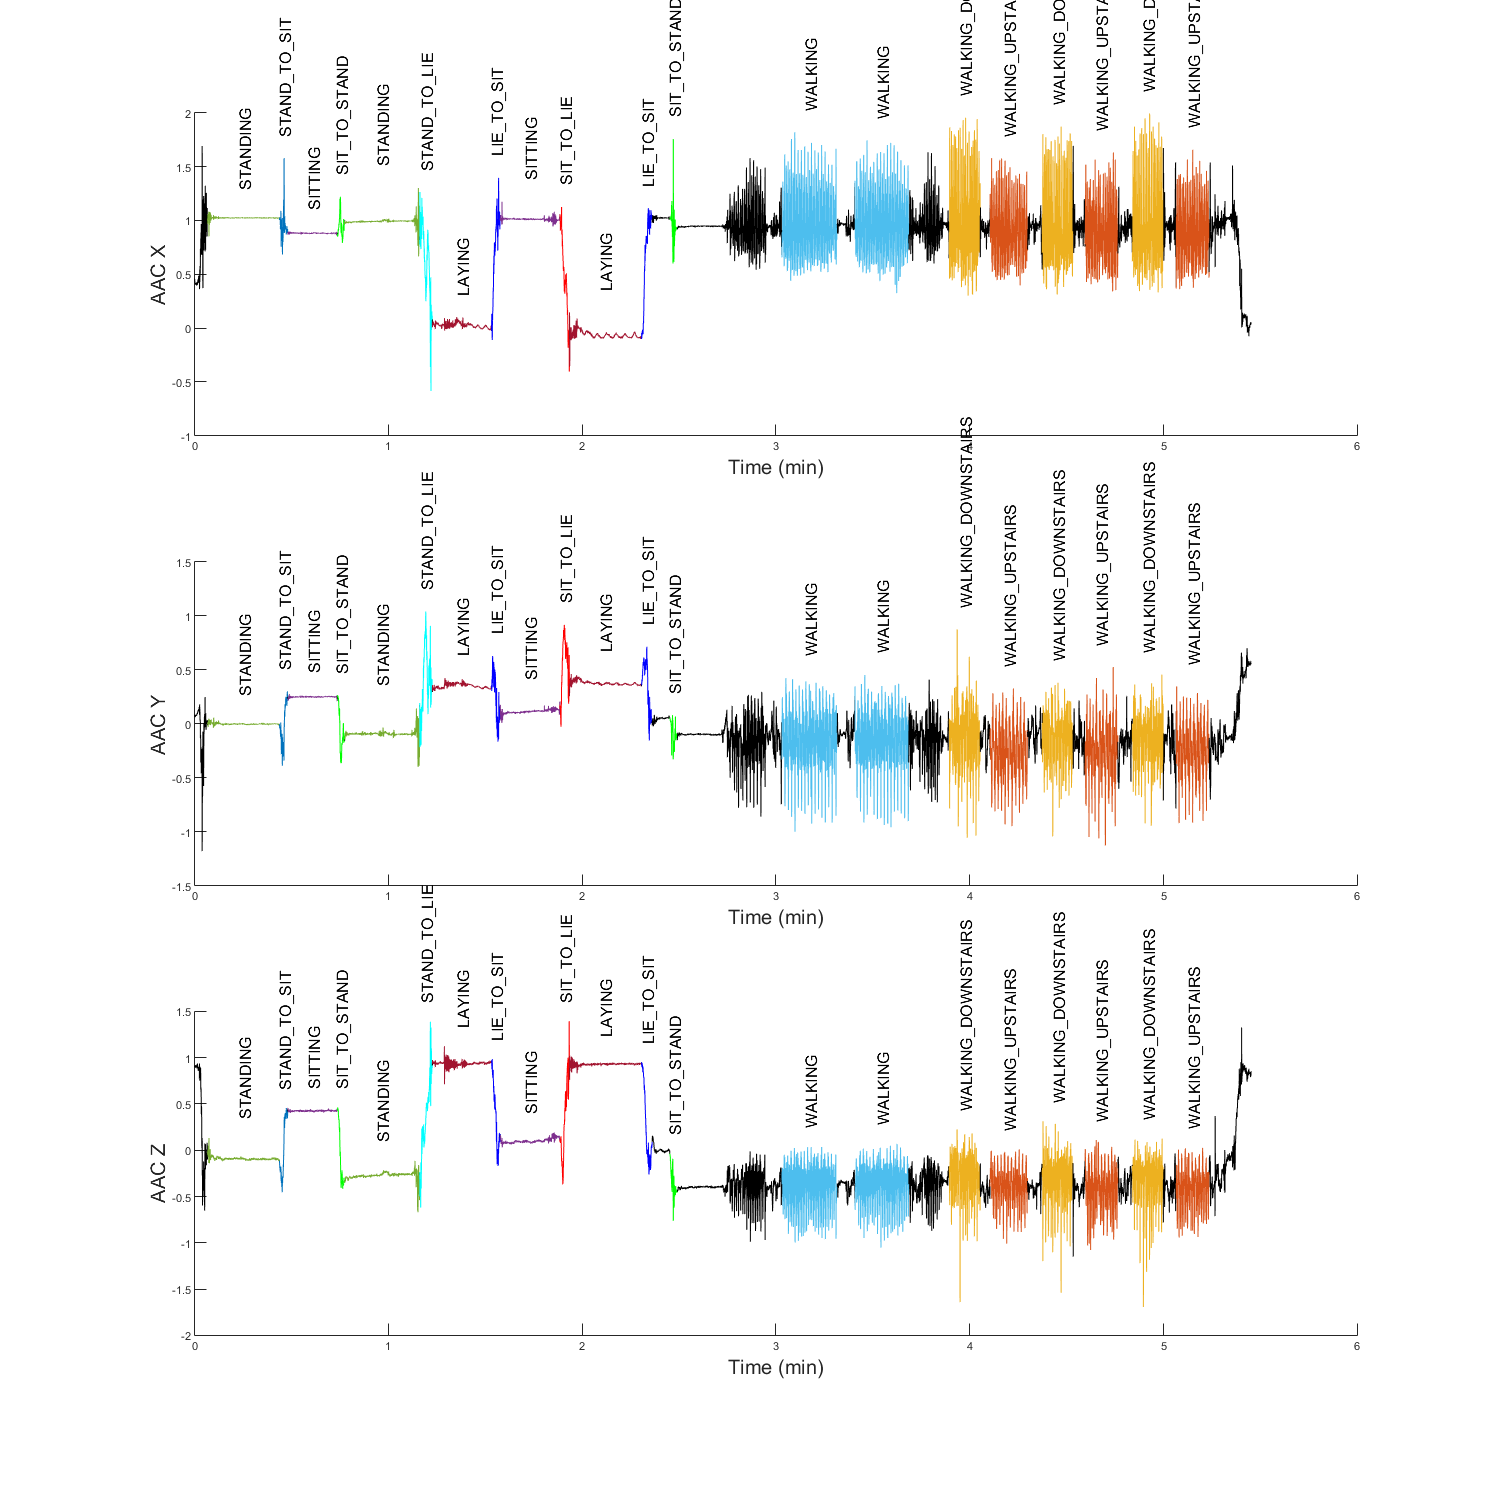

In [78]:
%plot -b inline -w 1500 -h 1500
experiencias = zeros(length(data),1);
for i = 1:length(data)
    experiencias(i) = data{i}.exp_num;
end
[indx,~] = listdlg('ListString', num2str(experiencias), 'SelectionMode','single', 'Name', ...
            'Escolha uma experiencia para visualizar');
user_plot(data, activity_label, indx, fs);

In [11]:
%%file user_plot.m
function user_plot(data, activity_label, index, fs)

colors = ['#4DBEEE';'#D95319';'#EDB120';'#7E2F8E';'#77AC30';'#A2142F';'#0072BD';'#00FF00';'#FF0000'; ...
          '#0000FF';'#00FFFF';'#FF00FF'];

figure(1);
indexes = 1:length(data{index}.data);
indexes = indexes./fs./60;

%Adicionar dados no plot(LETRA X)
letter = 88;
for ax = 1:3
    subplot(3,1,ax);
    hold on
    start = 1;
    for i = 1: length(data{index}.activity.number)
        label_begin = cell2mat(data{index}.activity.start(i));
        label_end = cell2mat(data{index}.activity.end(i));
        if label_begin > start
            data_range = start:label_begin;
            data_output = data{index}.data(data_range,ax);
            plot(indexes(data_range),data_output, 'k');
        end
        %obter atividade
        actv_num = cell2mat(data{index}.activity.number(i));
        data_range = label_begin:label_end;
        data_output = data{index}.data(data_range,ax);
        plot(indexes(data_range),data_output, 'color', colors(actv_num,:));
        start = label_end;
        text_pos_y = max(data_output) + 0.2;
        txt = activity_label(actv_num);
        t = text(double(indexes(round((label_begin+label_end)/2))), text_pos_y,txt , 'Interpreter' , 'none');
        t.FontSize = 12;
        t.Rotation = 90;
    end
    data_range = (start:length(data{index}.data(:,ax)));
    data_output = data{index}.data(data_range,ax);
    plot(indexes(data_range), data_output, 'k');
    xlabel("Time (min)", 'FontSize' , 15);
    ylabel(strcat("AAC ", char(letter)), 'FontSize' , 15);
    letter = letter + 1;
    hold off
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\user_plot.m'.


## 3. Calcular DFT associado a cada atividade, para todos os utilizadores 

## Análise teórica das janelas

### Uma pequena Introdução
Numa primeira fase, isso precisamos de perceber o funcionamento da transformada de Fourier, no nosso caso, em tempo discreto (Devido as limitações computacionais).

Ao aplicar esta transformada pretendemos obter uma **representação em frequencia do sinal original**, para isso, vamos decompomo-lo numa soma cossenos, obtendo assim as frequencias do sinal original, bem como a sua amplitude **num determinado periodo**.

![](Imagens\DFT.png)

*Sendo*:
- *m&Omega;<sub>0</sub> - A frequências angular*
- *C<sub>m</sub> - A magnitude da frequencia correspondente*
- *&Theta;m - A fase da sinusóide*


### O efeito das janelas

Iniciando a análise de janelas numa perspetiva teórica, sabemos que o sucesso ou não da análise de sinais com uso da transformada DTF pode depender, em grande escala, do tipo de janela a utilizar.
Isto porque as diferenças entre janelas afetam a componente espectral e de resolução em frequencia das janelas.

**Que paramentros analisar?**
- Side Lobe Atenuation: Pretendemos obter o menor Side Lobe possivel, logo uma elevada side lobe atenuation, pois assim conseguimos obter maior energia na frequencia 0 e por isso maior resolução espectral da transformada na frequencia principal, facilitando assim a nossa análise.
- Mainlobe width (-3db): Pretendemos obter o menor mainlobe width possivel, isto porque perdemos resolução espectral quando a largura é mais elevada, o que pode ser prejudicial.
- Spectral leakage: Para entende-lo, temos de relembrar que a transformada DFT considera uma repetição periodica do mesmo sinal e entendendo o que os fenómenos anteriores causam, quando analisamos um sinal não periódico, vazamentos, que normalmente analisamos a partir dos *side lobs* da transformada DFT.<br>Numa representação gráfica deste exemplo podemos utilizar uma função periódica, mas aplicando a DFT a periodo errado.
![](Imagens\Sleakage.png)

- Noise Bandwidth: Este parametro permite-nos analisar, alem dos anteriores, o erro ou ruído causado pela utilização de diferentes janelas, na análise da DFT.


**Vamos apenas realizar uma breve enunciação de cada janela que teorizamos utilizar**
- Janela retangular: A janela retangular, ou seja, a aplicacão da DFT ao espectro de dados sem utilização de nenhuma alteração causa um elevado efeito de *Spectral Leakage*, sendo por isso utilizada como "termo de referencia" para a utilização de outras janelas.
- Janela de Hann: A janela de Hann, a teremos um *Mainlobe width* superior, isto é, menor resolução em frequencia, no entanto ganhamos com a redução do efeito de *Spectral Leakage*.
- Janela de Hamming: A janela de Hamming, surgiu como uma alteração à janela de Hann, tentando reduzir ainda mais os erros de Side Lobe, aumentando a resolução espectral, com uma *Main lobe width* inferior á janela de Hann.
- Janela de Flat Top: Com a Janela flat top, o objetivo é obter uma elevada resolução em frequencia na frequencia 0, mais relevante, a consequencia do sucesso ou não na nossa análise depende das atividades, isto porque, podemos ter atividades com frequencias relevantes fora da frequencia 0, que, com aplicação desta janela ficariam bastante reduzidas.  




---
### Aplicação prática

Neste ponto começamos a análise de dados com aplicação da DFT a todos os fragmento referente a uma atividade, para todos utilizadores.
Para melhorar a nossa análise posterior, guardámos também as larguras de erro dos sinais, para cada largura aplicada, isto porque pretendemos escolher entre quatro janelas, a que achamos ser a mais vantajosa para o projeto em questão, tendo em conta as análises de frequencia, para cada atividade


#### Bibliografia
- [Spectral Leakage and Zero-Padding of the Discrete Fourier Transform](https://dspillustrations.com/pages/posts/misc/spectral-leakage-zero-padding-and-frequency-resolution.html)<br>
- [Windows, Harmonic analysis, and the discrete Fourier transform](https://apps.dtic.mil/dtic/tr/fulltext/u2/a034956.pdf)<br>
- [An Iterative Hybrid Harmonics Detection Method
Based on Discrete Wavelet Transform and
Bartlett–Hann Window](https://www.mdpi.com/2076-3417/10/11/3922/pdf)<br>
- [Multirate FIR Filters for Interpolating and Desampling](https://www.sciencedirect.com/topics/engineering/hamming-window)

### Analise de consequencias de uso de cada uma das janelas

In [29]:
%Mostrar graficos erro das janelas por atividade
mean_size = get_mean_sizes(data);

[act_in,~] = listdlg('ListString', activity_label, 'SelectionMode','single', 'Name','Escolha uma experiencia para visualizar');

mean_activity_size = mean_size(act_in);

temp_window = hamming(mean_activity_size);
hamm = wvtool(temp_window);
hamm.Name = 'Janela de Hamming';
disp(strcat("Mean Hamming Window Noise Bandwith to activity ", activity_label(act_in)));
disp(enbw(temp_window, fs));

temp_window = hann(mean_activity_size);
h = wvtool(temp_window);
h.Name = 'Janela de Hann';
disp(strcat("Mean Hann Window Noise Bandwith to activity ", activity_label(act_in)));
disp(enbw(temp_window, fs));


temp_window = flattopwin(mean_activity_size);
flattop = wvtool(temp_window);
flattop.Name = 'Janela Flatop';
disp(strcat("Mean Flat Top Window Noise Bandwith to activity ", activity_label(act_in)));
disp(enbw(temp_window, fs));


%Make a window viewer with all windows for visual comparision
all_win = wvtool(hamming(mean_activity_size), hann(mean_activity_size), flattopwin( mean_size(act_in)));
all_win.Name = 'Juncão de todas as janelas';

Mean Hamming Window Noise Bandwith to activity WALKING
    0.0749

Mean Hann Window Noise Bandwith to activity WALKING
    0.0824

Mean Flat Top Window Noise Bandwith to activity WALKING
    0.2072




## Análise das janelas, por atividade

|Tipo de atividade| Atividade      |                               | Hamming     | Hann     | Flat Top |
|:---    | :---     | :---     | :---: | :---:   |:---: |
|**Dinamicas:**|
|                 | Walking        |                               |             |          |          |
|                 |                | Leakege Factor                |      0.04%  | 0.05%    |    0%    |
|                 |                | Relative Side Lobe Atenuation |      42.7 dB|   31.5 dB|  93.6 dB |
|                 |                | Mainlobe width (-3db)         | 0.0026855   | 0.0029297|0.0080566 |
|                 |                | Mean Noise Bandwidth          |    0.0749   | 0.0824   |0.2072    |
|                 |WALKING_UPSTRS  |                              |             |          |          |
|                 |                | Leakege Factor                |      0.04%  | 0.05%    |    0%    |
|                 |                | Relative Side Lobe Atenuation |      42.7 dB|   31.5 dB|  93.6 dB |
|                 |                | Mainlobe width (-3db)         |   0.0041504 |0.0046387 |0.012207  |
|                 |                | Mean Noise Bandwidth          |0.1122       |0.1236    |0.3106    |
|                 | WALKING_DWSTRS |                               |             |          |          |
|                 |                | Leakege Factor                |     0.04%   |   0.05%  | 0%       |
|                 |                | Relative Side Lobe Atenuation |     42.7 dB |  31.5 dB |  93.6 dB |
|                 |                | Mainlobe width (-3db)         |  0.0043945  | 0.0048828| 0.012939 |
|                 |                | Mean Noise Bandwidth          | 0.1199      |   0.1320 |   0.3319 |
|**Estáticas:**   |
|                 | SITTING        |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  93.6 dB |
|                 |                | Mainlobe width (-3db)         |0.0029297    | 0.0031738| 0.0085449|
|                 |                | Mean Noise Bandwidth          |  0.0787     |    0.0866|   0.2177 |
|                 | STANDING       |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  93.6 dB |
|                 |                | Mainlobe width (-3db)         |   0.0024414 | 0.0026855| 0.0073242|
|                 |                | Mean Noise Bandwidth          |     0.0683  |   0.0752 | 0.1891   |
|                 | LAYING         |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  93.6 dB |
|                 |                | Mainlobe width (-3db)         |0.0026855    |0.0029297 |0.0078125 |
|                 |                | Mean Noise Bandwidth          |    0.0727   | 0.0800   | 0.2012   |
|**De transição:**|
|                 | STAND_TO_SIT   |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.6 dB    |  31.5 dB |  91.8 dB |
|                 |                | Mainlobe width (-3db)         |   0.017578  | 0.019531 | 0.050781 |
|                 |                | Mean Noise Bandwidth          |    0.4658   |  0.5137  |   1.2912 |
|                 | SIT_TO_STAND   |                               |             |          |          |
|                 |                | Leakege Factor                |  0.03%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.6 dB    |  31.5 dB |  90.6 dB |
|                 |                | Mainlobe width (-3db)         |    0.023438 |  0.025391|  0.068359|
|                 |                | Mean Noise Bandwidth          |     0.6411  |   0.7075 |    1.7785|
|                 | SIT_TO_LIE     |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  92.5 dB |
|                 |                | Mainlobe width (-3db)         |     0.012695|  0.014648| 0.038086 |
|                 |                | Mean Noise Bandwidth          |      0.3544 |   0.3906 |  0.9819  |
|                 | LIE_TO_SIT     |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.6 dB    |  31.5 dB |  92.1 dB |
|                 |                | Mainlobe width (-3db)         |   0.014648  |  0.016602| 0.043945 |
|                 |                | Mean Noise Bandwidth          |   0.4049    |    0.4464| 1.1221   |
|                 | STAND_TO_LIE   |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  93 dB   |
|                 |                | Mainlobe width (-3db)         |  0.0097656  | 0.01123  |  0.028809|
|                 |                | Mean Noise Bandwidth          |    0.2659   | 0.2930   |   0.7364 |
|                 | LIE_TO_STAND   |                               |             |          |          |
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  92.4 dB |
|                 |                | Mainlobe width (-3db)         |   0.013672  |  0.015625| 0.040039 |
|                 |                | Mean Noise Bandwidth          |     0.3698  |  0.4076  |   1.0245 |
|**Valores médios:**|
|                 |                | Leakege Factor                |  0.04%      |  0.05%   |   0%     |
|                 |                | Relative Side Lobe Atenuation |  42.7 dB    |  31.5 dB |  92.4 dB |
|                 |                | Mainlobe width (-3db)         |   0.013672  |  0.015625| 0.040039 |
|                 |                | Mean Noise Bandwidth          |     0.3698  |  0.4076  |   1.0245 |


In [25]:
%%file get_mean_sizes.m
function mean_size = get_mean_sizes(data)
    exp_indexes = 1:length(data);
    mean_size = zeros(12, 1);
    for i = 1:12
        n_am = 0;
        n_sum = 0;
        for experience = exp_indexes
            indexes = find(i == cell2mat(data{experience}.activity.number));
            len = cell2mat(data{experience}.activity.end(indexes)) - cell2mat(data{experience}.activity.start(indexes));
            n_sum = n_sum + sum(len);
            n_am = n_am + length(len);
        end
        mean_size(i) = round(n_sum / n_am);
    end
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\get_mean_sizes.m'.


### Visualização gráfica das janelas DFT
De forma a complementar a nossa análise decidimos implementar um metodo que permita visualizar gráficamente para os nossos dados, a influencia que cada janela causa, em cada atividade e eixo.

In [5]:
if ~isfile("data.mat")
    data = DFT(data);
end

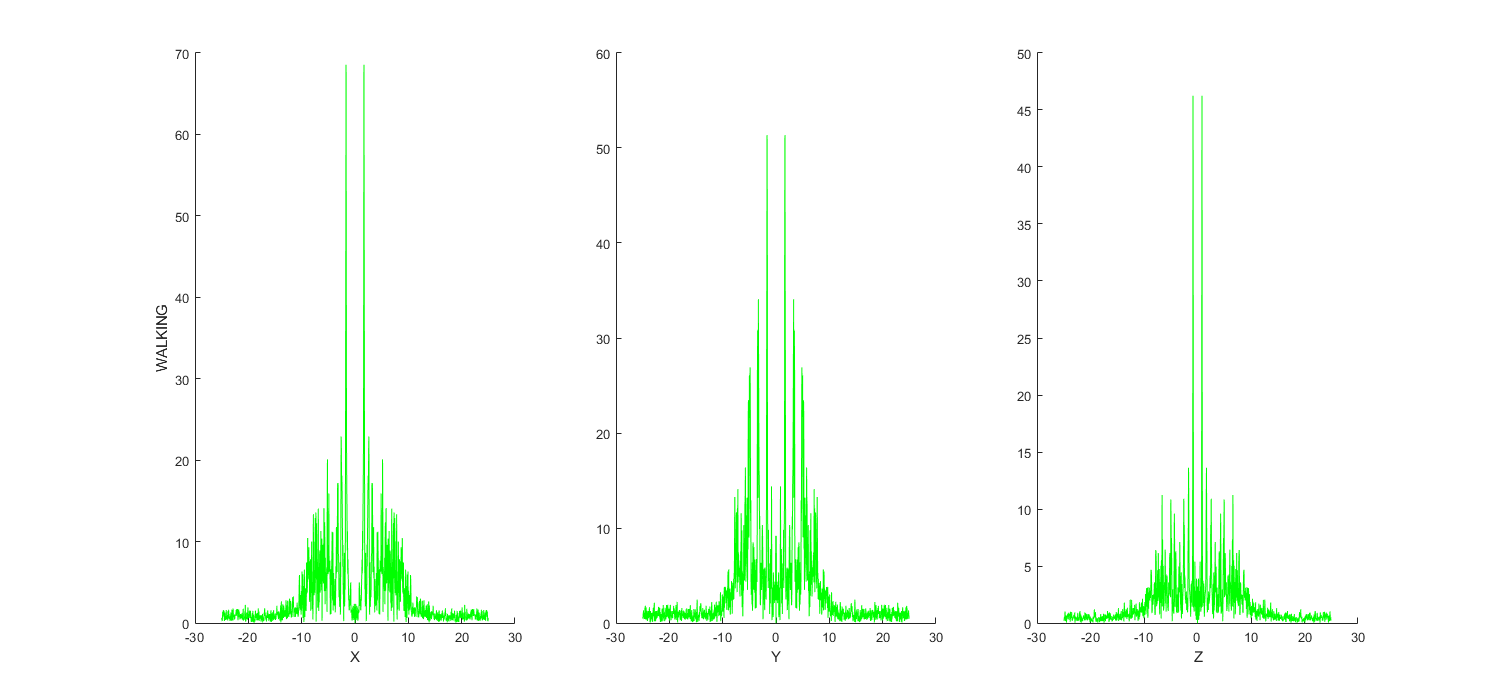

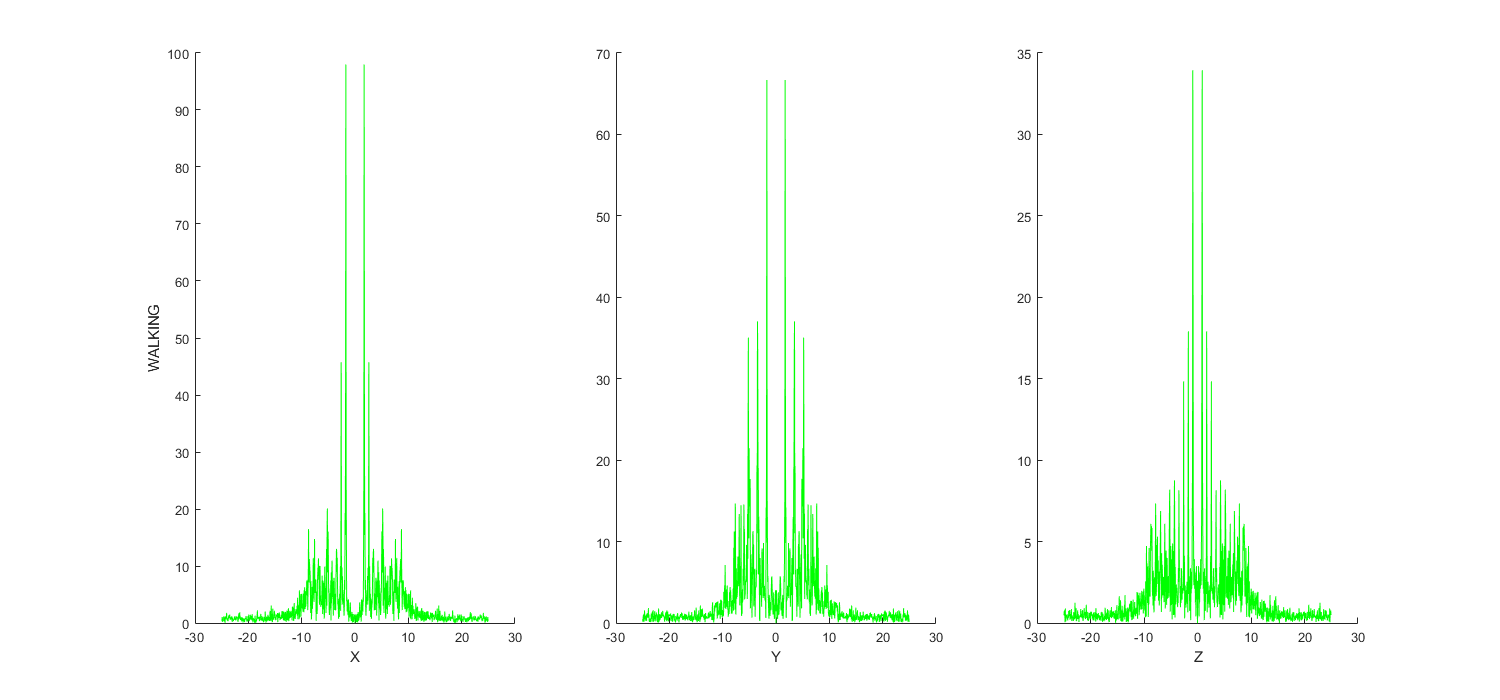

In [198]:
%plot -b inline -w 1500 -h 700
window_names = {'RETANGULAR', 'HAMMING', 'HANN', 'FLAT TOP'};

experiencias = zeros(length(data),1);
for i = 1:length(data)
    experiencias(i) = data{i}.exp_num;
end

%Perguntar dados ao utilizador
[exp_in,~] = listdlg('ListString', num2str(experiencias), 'SelectionMode','single', 'Name','Escolha uma experiencia para visualizar');
[act_in,~] = listdlg('ListString', activity_label, 'Name','Escolha uma experiencia para visualizar');
[windows,~] = listdlg('ListString', window_names, 'Name','Escolha uma ou mais janelas para visualizar');

DFT_PLOTS(data, exp_in, act_in, fs, activity_label, windows)


In [14]:
%%file DFT.m
function data = DFT(data)
for experience = 1:length(data)
    n_act_users = length(data{experience}.activity.number);
    for user_activity = 1:n_act_users
        
        start_index = cell2mat(data{experience}.activity.start(user_activity,1));
        end_index = cell2mat(data{experience}.activity.end(user_activity,1));
        data_range = start_index:end_index;
        data_s = length(data_range);
        for ax = 1:3
            %DFT Janela Retangular
            data_to_DFT = detrend(data{experience}.data(data_range, ax));
            data{experience}.activity.DFT_RECT{user_activity, ax} =  fftshift(fft(data_to_DFT));

            %DFT Janela Hamming
            window = hamming(data_s);
            data_to_DFT = detrend(data{experience}.data(data_range, ax)) .* window;
            data{experience}.activity.DFT_HAMMING{user_activity, ax} =  fftshift(fft(data_to_DFT));
         
            %DFT Janela Hann
            window = hann(data_s);
            data_to_DFT = detrend(data{experience}.data(data_range, ax)) .* window;
            data{experience}.activity.DFT_HANN{user_activity, ax} =  fftshift(fft(data_to_DFT));

            %DFT Janela Flat top
            window = flattopwin(data_s);
            data_to_DFT = detrend(data{experience}.data(data_range, ax)) .* window;
            data{experience}.activity.DFT_FLATOP{user_activity, ax} =  fftshift(fft(data_to_DFT));
        end
    end
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\DFT.m'.


In [197]:
%%file DFT_PLOTS.m
function DFT_PLOTS(data, experience,act_in, Fs, activity_label, windows)
colors = ['#00FF00';'#FF0000';'#0000FF';'#00FFFF';'#FF00FF'];

data_act_index = [];
for i = 1:length(act_in)
    indexes = find(cell2mat(data{experience}.activity.number) == act_in(i))';
    data_act_index = [data_act_index indexes];
end


for user_activity_index = 1:length(data_act_index)
   figure
   index = 0;
   user_activity = data_act_index(user_activity_index);
   start_index = cell2mat(data{experience}.activity.start(user_activity,1));
   end_index = cell2mat(data{experience}.activity.end(user_activity,1));
   data_range = start_index:end_index;
   N = length(data_range);
   if mod(N,2) == 0
            f = -Fs/2:Fs/N:Fs/2-Fs/N;
   else
            f = -Fs/2 + Fs/N/2:Fs/N:Fs/2-Fs/N/2;
   end


   actv_num = cell2mat(data{experience}.activity.number(user_activity));
   ylabel(activity_label(actv_num));
   
   for ax = 1:3
        color = 1;
        subplot(1, 3, index + ax);
        hold on
        if ismember(1, windows)
            DFT_RECT = data{experience}.activity.DFT_RECT{user_activity, ax};
            plot(f, abs(DFT_RECT), '-', 'color', colors(color, :));
        end
        color = color + 1;
        if ismember(2, windows)
            DFT_HANN = data{experience}.activity.DFT_HANN{user_activity, ax};
            plot(f, abs(DFT_HANN), '-', 'color', colors(color, :));
        end
        color = color + 1;
        if ismember(3, windows)
            DFT_HAMMING = data{experience}.activity.DFT_HAMMING{user_activity, ax};
            plot(f, abs(DFT_HAMMING), '-', 'color', colors(color, :));
        end
        color = color + 1;
        if ismember(4, windows)
            DFT_FLATOP = data{experience}.activity.DFT_FLATOP{user_activity, ax};
            plot(f, abs(DFT_FLATOP), '-', 'color', colors(color, :));
        end
        if ax == 1
            xlabel("X");
            ylabel(activity_label(actv_num), 'Interpreter' , 'none');
        elseif ax == 2
            xlabel("Y");
        else
            xlabel("Z");
        end
   end
   
   index = index + 3;
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\DFT_PLOTS.m'.


### CONCLUSÕES ACERCA DO ESTUDO DAS JANELAS


daas

asd

asd

as

d



## Análise espectral dos dados

De forma a realizar a análise espectral dos dados, iremos converter os dados resultantes das nossa DFT em magnitude, isto porque, para os varios utilizadores, teremos tamanhos de janelas diferentes e o resultado da DFT varia, mesmo dentro da mesma atividade, consoante o tamanho da janela.

In [6]:
if ~isfile("data.mat")
    data = Dft_to_mag(data);
end

In [195]:
%%file Dft_to_mag.m
function data = Dft_to_mag(data)
for experience = 1:length(data)
    n_act_users = length(data{experience}.activity.number);
    for user_activity = 1:n_act_users
        for ax = 1:3
            dft_abs = abs(data{experience}.activity.DFT_RECT{user_activity, ax});
            
            N = length(dft_abs);
            mid_index = floor(N/2) + 1;
            dft_abs = dft_abs(mid_index:N, 1);
            data{experience}.activity.Magn{user_activity, ax} = zeros(length(dft_abs),1);
            %Calcular C0
            data{experience}.activity.Magn{user_activity, ax}(1,1) = dft_abs(1, 1)/N;
            %Calcular Cm
            if mod(N,2) == 0
                data{experience}.activity.Magn{user_activity, ax}(2:mid_index - 1,1) =  2 .* dft_abs(2:mid_index - 1, 1)./ N;
            else
                data{experience}.activity.Magn{user_activity, ax}(2:mid_index,1) =  2 .* dft_abs(2:mid_index, 1)./ N;
            end
              
        end
    end
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\Dft_to_mag.m'.


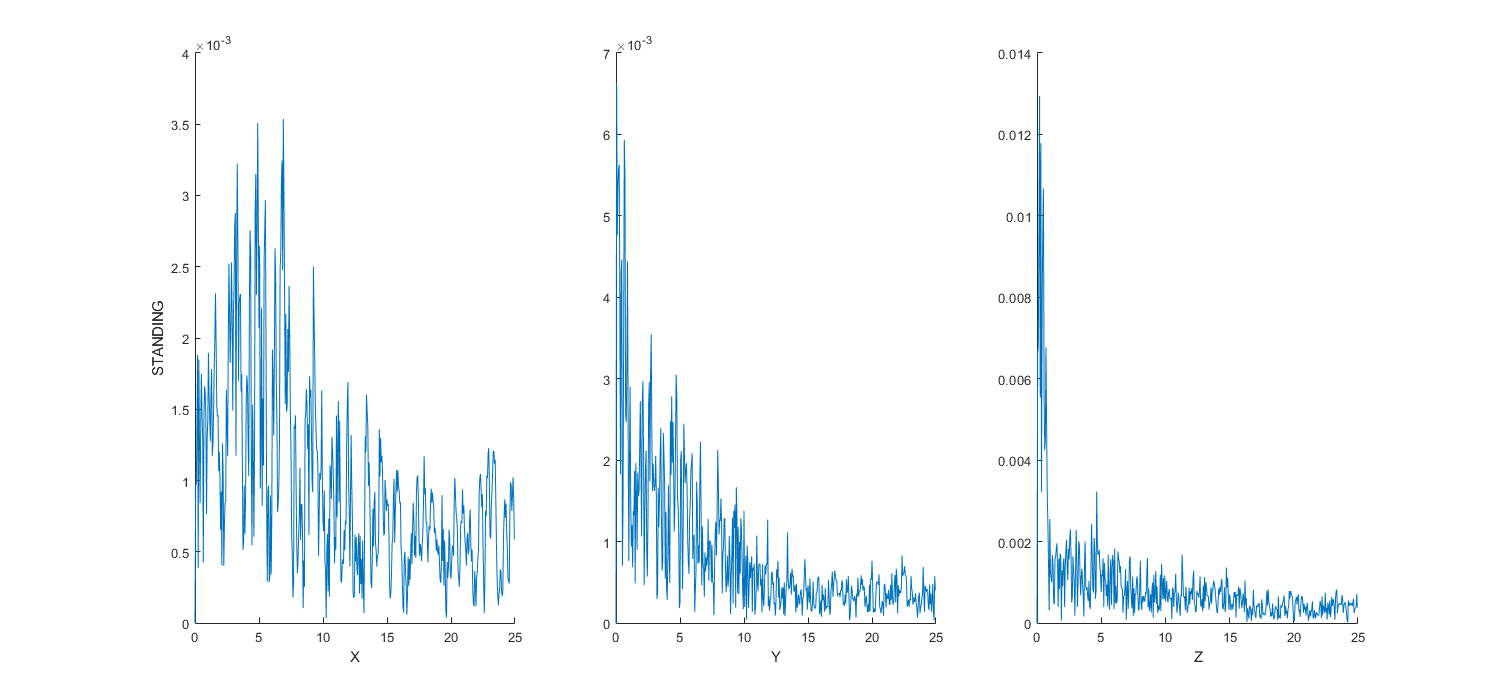

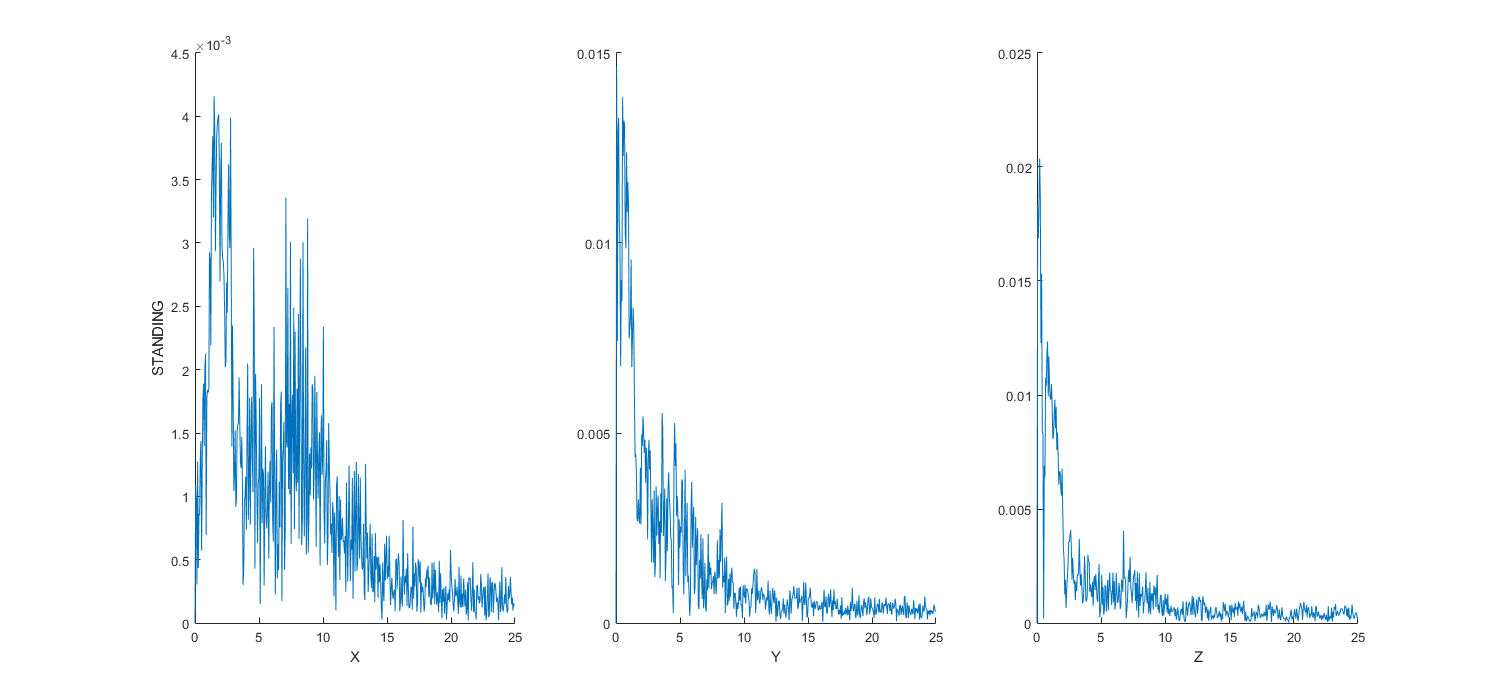

In [9]:
%plot -b inline -w 1500 -h 700
experiencias = zeros(length(data),1);
for i = 1:length(data)
    experiencias(i) = data{i}.exp_num;
end

[exp_in,~] = listdlg('ListString', num2str(experiencias), 'SelectionMode','single', 'Name','Escolha uma experiencia para visualizar');
[act_in,~] = listdlg('ListString', activity_label, 'Name','Escolha uma experiencia para visualizar');

MAG_PLOTS(data, exp_in, act_in, fs, activity_label);


In [20]:
%%file MAG_PLOTS.m
function MAG_PLOTS(data, experience, act_in, Fs, activity_label)

data_act_index = [];
for i = 1:length(act_in)
    indexes = find(cell2mat(data{experience}.activity.number) == act_in(i))';
    data_act_index = [data_act_index indexes];
end


for user_activity_index = 1:length(data_act_index)
   figure
   index = 0;
   user_activity = data_act_index(user_activity_index);
   start_index = cell2mat(data{experience}.activity.start(user_activity,1));
   end_index = cell2mat(data{experience}.activity.end(user_activity,1));
   data_range = start_index:end_index;
   N = length(data_range);
   if mod(N,2) == 0
            f = 0:Fs/N:Fs/2-Fs/N;
   else
            f = 0:Fs/N:Fs/2-Fs/N/2;
   end
   actv_num = cell2mat(data{experience}.activity.number(user_activity));
   for ax = 1:3
        subplot(1, 3, index + ax);
        hold on
        Magni = data{experience}.activity.Magn{user_activity, ax};
        plot(f, abs(Magni), '-'); 
        if ax == 1
            xlabel("X");
            ylabel(activity_label(actv_num), 'Interpreter' , 'none');
        elseif ax == 2
            xlabel("Y");
        else
            xlabel("Z");
        end
   end
   index = index + 3;
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\MAG_PLOTS.m'.


## Análise de caracteristicas para cada atividade e utilizador

Depois de transformar a nossa DFT em Paramentro de Magnitude, iremos tentar, numa primeira fase, visualizar os dados por atividade e utilizador e perceber gráficamente alguns parametros que nos permitam ajudar a identificar as principais caracteristicas espectrais, bem como as diferenças as mesmas atividades, tendo utilizadores diferentes.

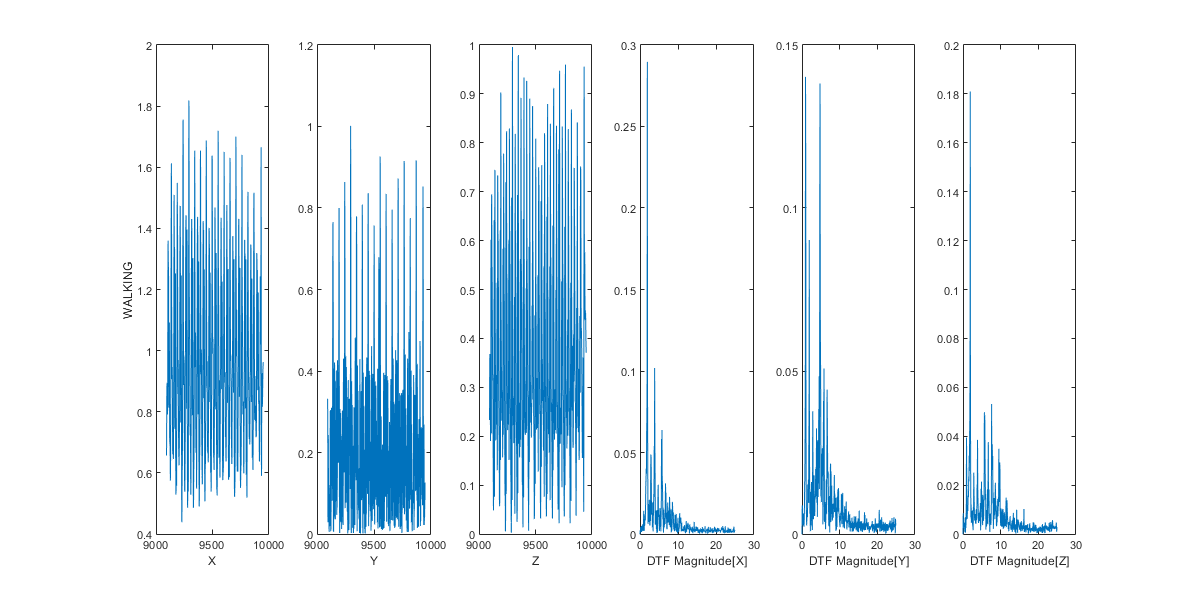

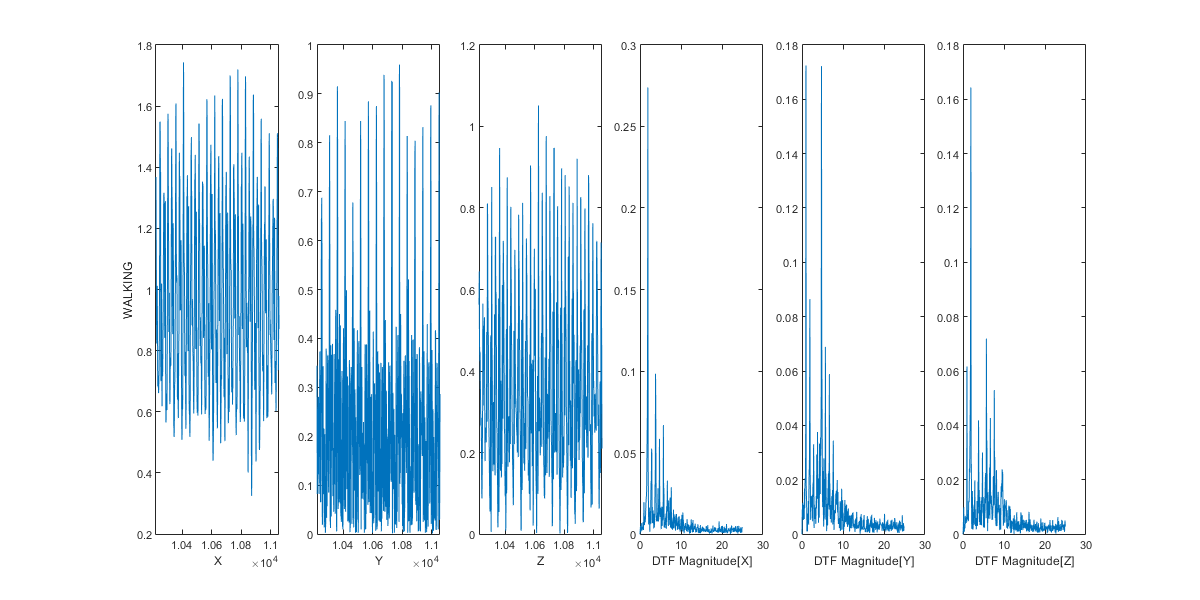

In [76]:
%plot -b inline -w 1200 -h 600
experiencias = zeros(length(data),1);
for i = 1:length(data)
    experiencias(i) = data{i}.exp_num;
end

[exp_in,~] = listdlg('ListString', num2str(experiencias), 'SelectionMode','single', 'Name',...
                    "Escolha uma experiencia para visualizar');
[act_in,~] = listdlg('ListString', activity_label, 'Name','Escolha uma experiencia para visualizar');

SPECTRAL_PLOTS(data, exp_in, act_in, fs, activity_label);


In [29]:
%%file SPECTRAL_PLOTS.m

function SPECTRAL_PLOTS(data, experience, act_in, Fs, activity_label)

data_act_index = [];
for i = 1:length(act_in)
    indexes = find(cell2mat(data{experience}.activity.number) == act_in(i))';
    data_act_index = [data_act_index indexes];
end
for user_activity_index = 1:length(data_act_index)
   figure
   index = 0;
   user_activity = data_act_index(user_activity_index);
   start_index = cell2mat(data{experience}.activity.start(user_activity,1));
   end_index = cell2mat(data{experience}.activity.end(user_activity,1));
   
   data_range = start_index:end_index;
   N = length(data_range);
   
   if mod(N,2) == 0
            f = 0:Fs/N:Fs/2-Fs/N;
   else
            f = 0:Fs/N:Fs/2-Fs/N/2;
   end
   
   actv_num = cell2mat(data{experience}.activity.number(user_activity));
   for ax = 1:3
        %Plot data
        subplot(1, 6, index + ax);
        data_to_plot = data{experience}.data(data_range, ax);
        plot(data_range, abs(data_to_plot), '-'); 
        if ax == 1
            xlabel("X");
            ylabel(activity_label(actv_num), 'Interpreter' , 'none');
        elseif ax == 2
            xlabel("Y");
        else
            xlabel("Z");
        end
        
        % Plot Magnitude em frequencia
        subplot(1, 6, 3 + index + ax);
        data_to_plot = data{experience}.activity.Magn{user_activity, ax};
        plot(f, abs(data_to_plot), '-'); 
        
        if ax == 1
            xlabel("DTF Magnitude[X]");
        elseif ax == 2
            xlabel("DTF Magnitude[Y]");
        else
            xlabel("DTF Magnitude[Z]");
        end
        
   end
   index = index + 3;
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\SPECTRAL_PLOTS.m'.


Gráficamente conseguimos observar o que já se esperava, devido ás diferenças entre cada pessoa, achamos que as frequencias obtidas variam de utilizador para utilizador, podemos também observar que, até mesmo num individuo, encontram-se diferenças por vezes substanciais de magnitudes.<br><br>
Para comprovar a nossa teoria decidimos recolher, para cada atividade e utilizador, as frequencias de magnitude superior a 80%, e as respetivas magnitudes pois depois de alguns testes, nos pareceu o valor mais indicado para nos apresentar uma estatistica mais realista do valor máximo de magnitude e frequencia correspondente áquela atividade, para assim podermos fazer uma análise mais estatistica, alem de visual, das frequencias mais influentes do nosso sinal.

In [64]:
%Neste bloco pretendemos escolher fazer a análise em magnitude ou frequencia,
% para termos mais do que um termo de comparação entre atividades
data = Spectral_relevance(data, fs);

In [62]:
%%file Spectral_relevance.m
function data = Spectral_relevance(data, Fs)
for experience = 1:length(data)
    n_act_users = length(data{experience}.activity.Magn);
    for user_activity = 1:n_act_users
        N = length(data{experience}.activity.DFT_RECT{user_activity, 1});
        if mod(N,2) == 0
                f = 0:Fs/N:Fs/2-Fs/N;
        else
                f = 0:Fs/N:Fs/2-Fs/N/2;
        end
        for ax = 1:3
            magn = cell2mat(data{experience}.activity.Magn(user_activity, ax));
            %Definir relevancia das frequencias
            min_mag = 0.90 * max(abs(magn));
            [~, locs] = findpeaks(abs(magn), 'MinPeakHeight', min_mag);
            data{experience}.activity.fRelevant{user_activity, ax} = f(locs)';
            data{experience}.activity.MagnRelevant{user_activity, ax} = magn(locs);
        end
    end
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\Spectral_relevance.m'.


### Análise estatistica por atividade e utilizador

Com os dados obtidos anteriormente, decidimos fazer uma tabela, dividida por utilizador, atividade e eixo com a média e a variância das correspondentes frequencias mais relevantes, para assim conseguirmos obter um valor médio e uma estatistica de erros, e facilitar a observação de possiveis padrões.

In [66]:
% Neste bloco dividimos a frequencias ou magnitudes mais relevantes, obtidas anteriormente por atividade e utilizador
act_user_m_freqs = Spectral_user_act_mean(data, 1);
act_user_m_Magn = Spectral_user_act_mean(data, 0);

In [171]:
%%file Spectral_user_act_mean.m
function act_user_m = Spectral_user_act_mean(data, infreq)
n_user = 0;
users_array = [];
for experience = 1:length(data)
    user = data{experience}.user;
    if ~ismember(user, users_array)
        users_array = [users_array user];
        n_user = n_user + 1;
    end
end

act_user_m = cell(n_user , 1);
for i = 1:n_user
    act_user_m{i}.user = users_array(i);
    act_user_m{i}.act_mean = cell(12,3);
end

for experience = 1:length(data)
    n_act_users = length(data{experience}.activity.Magn);
    user = data{experience}.user;
    user_index = find(users_array == user);
    for user_activity = 1:n_act_users        
        act_num = cell2mat(data{experience}.activity.number(user_activity));
        for ax = 1:3
            if(infreq == 1)
                data_in = cell2mat(data{experience}.activity.fRelevant(user_activity, ax));
            else
                data_in = cell2mat(data{experience}.activity.MagnRelevant(user_activity, ax));
            end
            temp_data = cell2mat(act_user_m{user_index}.act_mean(act_num, ax));
            new = [temp_data data_in'];
            act_user_m{user_index}.act_mean{act_num, ax} = new;
        end
    end
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\Spectral_user_act_mean.m'.


In [67]:
% Apresenta dados divididos por utilizador, atividade e eixo, numa tabela
disp("Análise de dados em Frequencia:");
user_act_table(act_user_m_freqs, activity_label);
disp("Análise de dados em Magnitude:");
user_act_table(act_user_m_Magn, activity_label);

Análise de dados em Frequencia:
                                          Tabela de dados e atividade utilizador 5

                          X -> Mean       Variance    Y -> Mean       Variance    Z -> Mean       Variance
                          ________________________    ________________________    ________________________

    WALKING                 1.7671     0.0074331        1.7671     0.0074331        1.0888       0.18644  
    WALKING_UPSTAIRS        1.6549     0.0052949        1.6549     0.0052949       0.81564     0.0035755  
    WALKING_DOWNSTAIRS      1.8047      0.019787        3.1033        1.0712       0.90379      0.010172  
    SITTING                 4.3752        18.504        1.5274        3.7136       0.34106      0.044958  
    STANDING                2.8988        5.5988       0.25224      0.054437       0.29623      0.043114  
    LAYING                 0.72466       0.55463        4.1987         10.52       0.24286      0.025285  
    STAND_TO_SIT           

In [96]:
%%file user_act_table.m
function user_act_table(act_user_m,activity_label)
for i = 1:length(act_user_m)
    for user_activity = 1:12
        for ax = 1:3
            temp_data = cell2mat(act_user_m{i}.act_mean(user_activity, ax));
            media = mean(temp_data);
            varian = var(temp_data);
            act_user_m{i}.act_mean{user_activity, ax} = [];
            act_user_m{i}.act_mean{user_activity, ax} = [media varian];
        end
    end
end

for i = 1:length(act_user_m)
    user_name = int2str(act_user_m{i}.user);
    disp("                                          Tabela de dados e atividade utilizador " + user_name + newline);
    x_name = "X -> Mean       Variance";
    y_name = "Y -> Mean       Variance";
    Z_name = "Z -> Mean       Variance";
    T = cell2table(act_user_m{i}.act_mean, 'VariableNames', [x_name,y_name, Z_name],  'RowNames', activity_label);
    disp(T);
    disp("" + newline + newline);
end
end


Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\user_act_table.m'.


#### Analise tabela Atividade-Utilizador
Depois de observar a tabela, conseguimos obter algumas conclusões.<br>
Tal como previsto, na generalidade observamos variações entre individuos, no entanto já conseguimos identificar alguns padrões, bem como algumas possiveis dificuldades.<br>
Observamos que, em magnitude , por exemplo, as atividades estáticas são as que apresentam os menores valores, ou que, se pretendessemos analisar um sinal apenas em frequencia, o eixo z seria o indicado, pois é neste que obtemos os menores valores de variancia.<br>
No entanto, e de forma a obter dados mais exatos entre atividades, iremos fazer uma análise mais detalhada sobre cada tipo de atividade.

## Análise por tipo de atividade



In [68]:
act_m_freq = Spectral_act_mean(data, 1);
act_m_magn = Spectral_act_mean(data, 0);

In [1]:
%%file Spectral_act_mean.m
function act_m = Spectral_act_mean(data, infreq)

act_m = cell(12 , 3);
for experience = 1:length(data)
    n_act_users = length(data{experience}.activity.Magn);
    for user_activity = 1:n_act_users        
        act_num = cell2mat(data{experience}.activity.number(user_activity));
        for ax = 1:3
            if(infreq == 1)
                data_in = cell2mat(data{experience}.activity.fRelevant(user_activity, ax));
            else
                data_in = cell2mat(data{experience}.activity.MagnRelevant(user_activity, ax));
            end
            temp_data = act_m{act_num, ax};
            new = [temp_data data_in'];
            act_m{act_num, ax} = new;
        end
    end
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\Spectral_act_mean.m'.


In [69]:
disp("Análise de dados em Frequencia:");
act_table(act_m_freq, activity_label);

disp("Análise de dados em Magnitude:");
act_table(act_m_magn, activity_label);

Análise de dados em Frequencia:
                          X -> Mean       Variance    Y -> Mean       Variance    Z -> Mean       Variance
                          ________________________    ________________________    ________________________

    WALKING                  1.8029    0.0051105         2.5941      1.9603          1.2841     0.24528   
    WALKING_UPSTAIRS         1.7062     0.012596          1.491     0.13097          1.3242     0.80218   
    WALKING_DOWNSTAIRS       1.8439      0.03127         2.2514      1.2768          1.6185      1.8286   
    SITTING                  3.0783       6.6187        0.80855      1.6789         0.31165    0.083072   
    STANDING                 5.3302       14.094        0.39377     0.37353         0.20554    0.034215   
    LAYING                  0.41777      0.26032         2.8552      8.8965          1.2273      4.3912   
    STAND_TO_SIT             1.3806       1.9934        0.47044    0.012467         0.66627    0.026372   
    

In [24]:
%%file act_table.m

function act_table(act_m_freq,activity_label)



x_name = "X -> Mean       Variance";
y_name = "Y -> Mean       Variance";
Z_name = "Z -> Mean       Variance";
T = cell2table(act_m, 'VariableNames', [x_name,y_name, Z_name],  'RowNames', activity_label);
disp(T);
disp("" + newline + newline);

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\act_table.m'.


## Calculo de numero de passos médio por minuto

Para calcular o numero de passos médio por minuto, teremos por base os valores médios de frequencias mais relevantes por atividade e utilizador calculados anteriormente. Sabemos que, a frequencia da amostra sera o numero de vezes que cada eixo será movimentado por segundo, posto isto, numa **atividade dinamica**, esta frequencia será uma **aproximação ao número de passos por segundo**, logo, ao multiplica-la por 60, teremos uma aproximação, para cada utilizador, do número de passos por minuto.

In [71]:
steps_table(act_user_m_freqs, activity_label)

                                          Numero médio de passos por atividade e utilizador 5

                          X -> Mean       Variance    Y -> Mean       Variance    Z -> Mean       Variance
                          ________________________    ________________________    ________________________

    WALKING                  106.03    0.44599           106.03    0.44599            65.33     11.187    
    WALKING_UPSTAIRS         99.295     0.3177           99.295     0.3177           48.938    0.21453    
    WALKING_DOWNSTAIRS       108.28     1.1872            186.2     64.269           54.228    0.61033    



                                          Numero médio de passos por atividade e utilizador 6

                          X -> Mean       Variance    Y -> Mean       Variance    Z -> Mean       Variance
                          ________________________    ________________________    ________________________

    WALKING                 105.38     0.076283         

EXPLICAÇÃO DOS PASSOS 

In [70]:
%%file steps_table.m
function steps_table(act_user_m_freqs, activity_label)
steps = cell(length(act_user_m_freqs), 1);
for i = 1:length(act_user_m_freqs)
    for user_activity = 1:3
        for ax = 1:3
            temp_data = cell2mat(act_user_m_freqs{i}.act_mean(user_activity, ax));
            media = mean(temp_data) * 60;
            varian = var(temp_data) * 60;
            steps{i}.user = act_user_m_freqs{i}.user;
            steps{i}.act_mean{user_activity, ax} = [];
            steps{i}.act_mean{user_activity, ax} = [media varian];
        end
    end
end

for i = 1:length(steps)
    user_name = int2str(steps{i}.user);
    disp("                                          Numero médio de passos por atividade e utilizador " + user_name + newline);
    x_name = "X -> Mean       Variance";
    y_name = "Y -> Mean       Variance";
    Z_name = "Z -> Mean       Variance";
    T = cell2table(steps{i}.act_mean, 'VariableNames', [x_name,y_name, Z_name],  'RowNames', activity_label(1:3, 1));
    disp(T);
    disp("" + newline);
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\steps_table.m'.


## Short-time Fourier Transform







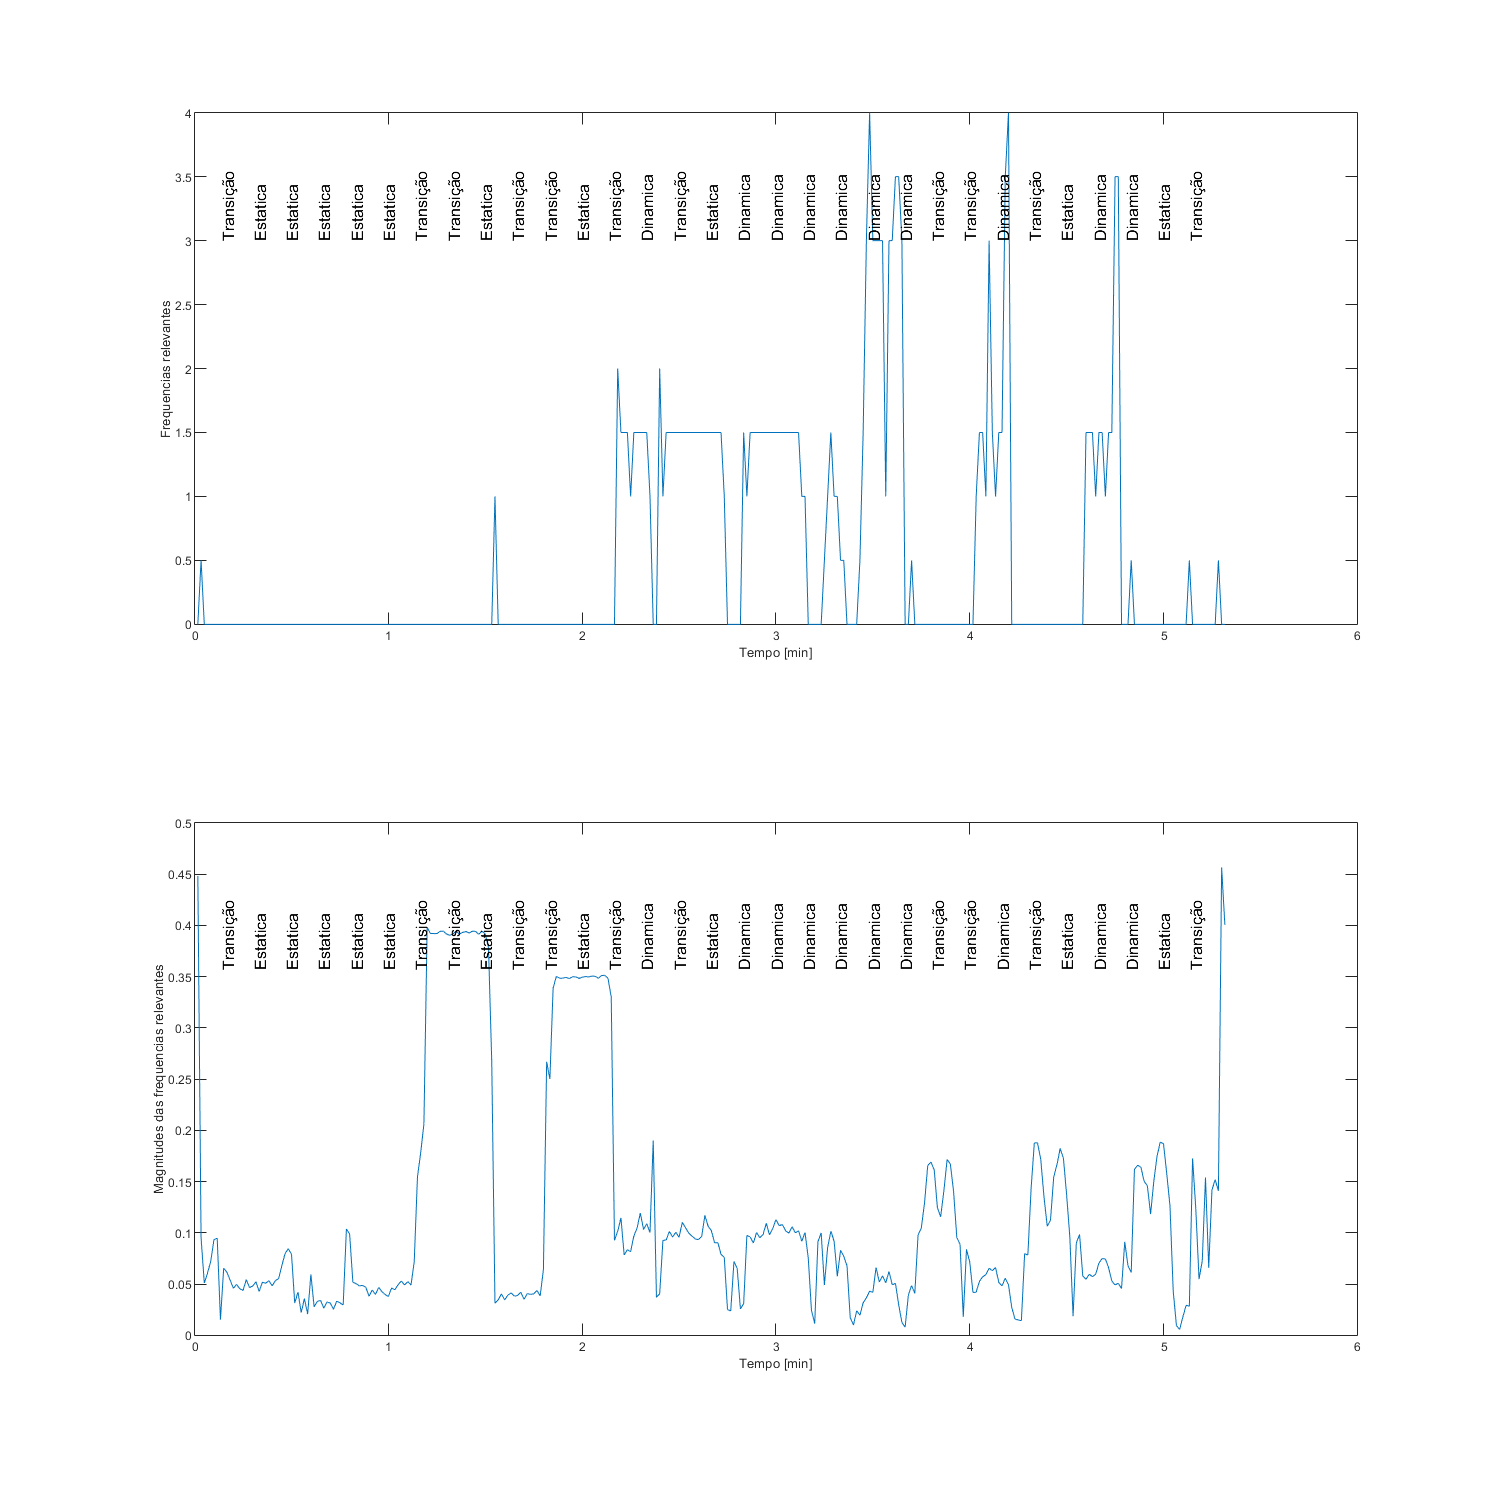

In [91]:
clear all
data = lerDados();

experiencias = zeros(length(data),1);
for i = 1:length(data)
    experiencias(i) = data{i}.exp_num;
end

[exp_in,~] = listdlg('ListString', num2str(experiencias), 'SelectionMode','single', 'Name','Escolha uma experiencia para visualizar');
data_z = data{exp_in,1}.data(:,3);
stft(data_z, 50);

In [90]:
%%file stft.m
function stft(data_z,Fs)
    Ts = 1/Fs; % Periodo de amostragem
    N = length(data_z); %Periodo fundamental de x
    
    t = linspace(0, (N-1) * Ts, N);
    %Variaveis tempo
    Tframe = 2;
    Toverlap = 1;

    %Relaçao tempo com indices
    Nframe = round(Tframe * Fs);
    Noverlap = round(Toverlap * Fs);

    if mod(Nframe,2) == 0
        f_frame = 0:Fs/Nframe:Fs/2-Fs/Nframe;
    else
        f_frame = 0:Fs/Nframe:Fs/2-Fs/Nframe/2;
    end

    h = hamming(Nframe);
    m_relev = [];
    f_relev = [];
    magn = [];
    nframes = 0;
    tframes = [];
    temp_nframes = 0;
    atividades = [];
    act_t_frames = [];
    for ii = 1:Nframe-Noverlap:N-Nframe+1
        % aplicar a janela ao sinal do tempo
        x_frame = data_z(ii:ii+Nframe-1).*h;

        % obter a magnitude da fft do sinal
        m_X_frame = abs(fftshift(fft(x_frame)));
        
        size_frame = length(m_X_frame);
        mid_index = floor(size_frame/2) + 1;
        m_X_frame = m_X_frame(mid_index:size_frame, 1);
        new_m_X_frame = zeros(size_frame,1);
        %Calcular C0
        new_m_X_frame = m_X_frame(1, 1)/size_frame;
        %Calcular Cm
        if mod(size_frame,2) == 0
            new_m_X_frame =  2 .* m_X_frame(2:mid_index - 1, 1)./ size_frame;
        else
            new_m_X_frame =  2 .* m_X_frame(2:mid_index, 1)./ size_frame;
        end

        % obter o máximo da magnitude do sinal
        m_X_frame_max = max(new_m_X_frame);
        magn = [magn new_m_X_frame];
        % encontrar os índices do máximo da magnitude do sinal
        ind = find(abs(new_m_X_frame-m_X_frame_max)<0.001);

        % encontrar as frequências correspondentes ao máximo de magnitude
        f_relev = [f_relev, f_frame(ind(1))];
        m_relev = [m_relev, m_X_frame_max];
        nframes = nframes+1;
        temp_nframes = temp_nframes + 1;
        % calcular o vetor de tempo correspondente a cada janela, que aqui
        % corresponde ao valor do vetor de tempos, t, em cada janela
        t_frame = t(ii:ii+Nframe-1);
        tframes = [tframes, t_frame(round(Nframe/2)+1)];
        
        if(temp_nframes == 10)
            m_relev_le = length(m_relev);
            desvio_padrao_magn = std(m_relev(m_relev_le - temp_nframes+1:m_relev_le));
            desvio_padrao_freq = std(f_relev(m_relev_le - temp_nframes+1:m_relev_le));
            if(desvio_padrao_magn > 0.04)
                atividades = [atividades "Transição"];
            else
                if(desvio_padrao_freq > 0.01)
                    atividades = [atividades "Dinamica"];
                else
                    atividades = [atividades "Estatica"];
                end
            end
            act_t_frames = [act_t_frames t_frame(round(Nframe/2)+ 1 - temp_nframes/2)];
            temp_nframes = 0;
        end
     end

     figure;
     subplot(2, 1, 1);
     text_pos = max(f_relev);
     plot(tframes./60, f_relev);
     for i = 1:length(act_t_frames)
        txt = atividades(i);
        t = text(act_t_frames(i)/60, text_pos-1,txt , 'Interpreter' , 'none');
        t.FontSize = 12;
        t.Rotation = 90;  
     end   
     xlabel("Tempo [min]");
     ylabel("Frequencias relevantes");
     subplot(2, 1, 2);
     plot(tframes./60, m_relev);
     text_pos = max(m_relev);
     for i = 1:length(act_t_frames)
        txt = atividades(i);
        t = text(act_t_frames(i)/60, text_pos-0.1,txt , 'Interpreter' , 'none');
        t.FontSize = 12;
        t.Rotation = 90;  
     end
     xlabel("Tempo [min]");
     ylabel("Magnitudes das frequencias relevantes");
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\stft.m'.
